# **Visual Sound Detection Model**

This notebook builds a computer vision classifier that learns from images located in the `images` folder. Each image file name is interpreted as its label. The pipeline covers environment setup, data ingestion, preprocessing, model training, evaluation, and an optional realtime webcam inference demo.

> **Note:** Add your images to `images/` before running the training steps. The notebook assumes a standard RGB image format (e.g., `.jpg`, `.png`).


In [51]:
import os
import sys
import math
import json
from pathlib import Path
from typing import Callable, Dict, List, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

# Optional: used later for webcam capture
try:
    import cv2
except ImportError:
    cv2 = None
    print("OpenCV (cv2) not found. Webcam inference cell will guide you through installing it.")

# Configure paths
PROJECT_ROOT = Path("/Users/raoabdul/Documents/Development/NextGen-Innovators/Ml Model")
IMAGE_DIR = PROJECT_ROOT / "images"
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# Basic reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Looking for images in: {IMAGE_DIR}")


TensorFlow version: 2.20.0
Looking for images in: /Users/raoabdul/Documents/Development/NextGen-Innovators/Ml Model/images


## **1. Dataset Discovery & Label Parsing**

This section scans the `images` directory, extracts labels from file names, and builds a dataframe describing the dataset. Customize `extract_label_from_name` if you prefer a different naming convention.


In [52]:
def extract_label_from_name(filename: str) -> str:
    """Derive a label from the image filename (without the extension).

    Strategy:
      1. Remove the file extension.
      2. Split on underscores, dashes, or spaces.
      3. Use the first token as the class name.

    Adjust this heuristic to match your naming scheme.
    """
    stem = Path(filename).stem
    for delimiter in ("_", "-", " "):
        if delimiter in stem:
            return stem.split(delimiter)[0].lower()
    return stem.lower()


def discover_dataset(image_dir: Path) -> pd.DataFrame:
    """Return a dataframe with columns [path, label]."""
    image_paths = sorted(
        p for p in image_dir.glob("**/*") if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}
    )
    if not image_paths:
        raise FileNotFoundError(
            f"No images found in {image_dir}. Add files before running training."
        )
    records = []
    for path in image_paths:
        label = extract_label_from_name(path.name)
        records.append({"path": path, "label": label})
    df = pd.DataFrame(records)
    return df


def summarize_dataset(df: pd.DataFrame) -> None:
    """Print summary statistics and plot label distribution."""
    print(f"Total images: {len(df)}")
    label_counts = df["label"].value_counts().sort_values(ascending=False)
    print("\nLabel distribution:")
    print(label_counts)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title("Image count per label")
    plt.tight_layout()
    plt.show()


def train_val_test_split(
    df: pd.DataFrame,
    train_frac: float = 0.7,
    val_frac: float = 0.2,
    test_frac: float = 0.1,
    seed: int = 42,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into train/validation/test subsets stratified by label.
    For very small datasets (<20 images total), adjusts splits automatically.
    """
    if not math.isclose(train_frac + val_frac + test_frac, 1.0, rel_tol=1e-5):
        raise ValueError("train_frac + val_frac + test_frac must sum to 1.0")

    total_images = len(df)
    num_classes = len(df["label"].unique())
    images_per_class = total_images // num_classes if num_classes > 0 else 0

    # Adjust splits for very small datasets
    if total_images < 20:
        # For very small datasets, use larger train split, skip test if too small
        train_frac = 0.85
        val_frac = 0.15
        test_frac = 0.0
        print(f"⚠️  Very small dataset detected ({total_images} images). Using adjusted splits: 85% train, 15% val, 0% test")

    df_shuffled = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    splits: Dict[str, List[pd.Series]] = {"train": [], "val": [], "test": []}

    for label, group in df_shuffled.groupby("label"):
        n = len(group)
        n_train = max(1, int(n * train_frac))
        n_val = max(1, int(n * val_frac)) if n >= 3 and val_frac > 0 else 0
        n_test = n - n_train - n_val if test_frac > 0 else 0
        splits["train"].append(group.iloc[:n_train])
        if n_val > 0:
            splits["val"].append(group.iloc[n_train : n_train + n_val])
        if n_test > 0:
            splits["test"].append(group.iloc[n_train + n_val :])

    train_df = pd.concat(splits["train"]).reset_index(drop=True)
    val_df = pd.concat(splits["val"]).reset_index(drop=True) if splits["val"] else pd.DataFrame()
    test_df = pd.concat(splits["test"]).reset_index(drop=True) if splits["test"] else pd.DataFrame()

    print(
        f"Split counts -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}"
    )
    return train_df, val_df, test_df


,path,label
0,/Users/raoabdul/Documents/Development/NextGen-...,socotra
1,/Users/raoabdul/Documents/Development/NextGen-...,socotra
2,/Users/raoabdul/Documents/Development/NextGen-...,socotra
3,/Users/raoabdul/Documents/Development/NextGen-...,socotra
4,/Users/raoabdul/Documents/Development/NextGen-...,socotra


Total images: 21

Label distribution:
label
greater    11
socotra    10
Name: count, dtype: int64


/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_87525/715245003.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


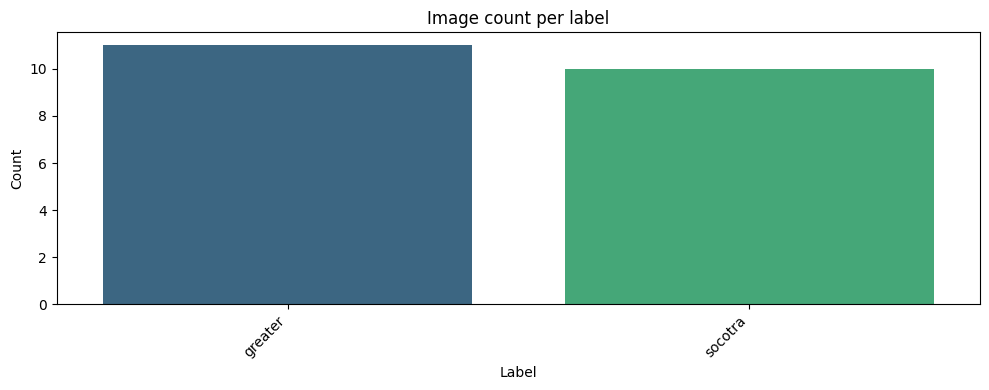

In [53]:
try:
    dataset_df = discover_dataset(IMAGE_DIR)
    display(dataset_df.head())
    summarize_dataset(dataset_df)
except FileNotFoundError as e:
    dataset_df = None
    print(e)
    print("Populate the images directory and rerun this cell when ready.")


## **2. Preprocessing Pipeline**

This section builds TensorFlow `tf.data.Dataset` pipelines with on-the-fly preprocessing and optional augmentation. Adjust the image size or augmentations to suit your dataset.


In [54]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE


def load_image(path: tf.Tensor) -> tf.Tensor:
    """Load an image from disk and resize it."""
    image = tf.io.read_file(path)
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    return image


def build_dataset(
    df: pd.DataFrame,
    class_to_index: Dict[str, int],
    augment: bool = False,
    aggressive_augment: bool = False,
) -> tf.data.Dataset:
    paths = df["path"].astype(str).values
    labels = df["label"].map(class_to_index).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load_and_preprocess(path, label):
        image = load_image(path)
        if augment:
            image = augment_image(image, aggressive=aggressive_augment)
        return image, tf.one_hot(label, depth=len(class_to_index))

    ds = ds.shuffle(len(df), seed=SEED)
    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


def augment_image(image: tf.Tensor, aggressive: bool = True) -> tf.Tensor:
    """
    Apply data augmentation. Use aggressive=True for small datasets.
    """
    # Random flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if aggressive:
        # More aggressive augmentation for small datasets
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.random_saturation(image, 0.6, 1.4)
        image = tf.image.random_hue(image, max_delta=0.1)
        # Random rotation (90 degree increments)
        image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
        # Random zoom via crop and resize (only if image is large enough)
        crop_size = int(IMG_SIZE[0] * 0.8)
        if crop_size > 0:
            image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
            image = tf.image.resize(image, IMG_SIZE)
    else:
        # Mild augmentation
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)
    
    # Ensure values stay in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image


def prepare_datasets(df: pd.DataFrame):
    labels = sorted(df["label"].unique())
    class_to_index = {label: idx for idx, label in enumerate(labels)}
    index_to_class = {idx: label for label, idx in class_to_index.items()}

    # Detect if we have a small dataset
    total_images = len(df)
    num_classes = len(labels)
    images_per_class = total_images // num_classes if num_classes > 0 else 0
    use_aggressive_aug = images_per_class < 50  # Use aggressive augmentation for small datasets

    train_df, val_df, test_df = train_val_test_split(df)

    train_ds = build_dataset(train_df, class_to_index, augment=True, aggressive_augment=use_aggressive_aug)
    val_ds = build_dataset(val_df, class_to_index, augment=False) if len(val_df) else None
    test_ds = build_dataset(test_df, class_to_index, augment=False) if len(test_df) else None

    return {
        "train": train_ds,
        "val": val_ds,
        "test": test_ds,
        "class_to_index": class_to_index,
        "index_to_class": index_to_class,
        "train_df": train_df,
        "val_df": val_df,
        "test_df": test_df,
    }


In [55]:
if dataset_df is not None:
    data_bundle = prepare_datasets(dataset_df)
else:
    data_bundle = None
    print("Dataset not prepared yet. Populate images and rerun.")


Split counts -> train: 14, val: 4, test: 3


## **3. Model Architecture**

We define a classifier that automatically adapts to your dataset size:

- **Small datasets (<50 images per class)**: Uses **transfer learning** with MobileNetV2 (pre-trained on ImageNet). This leverages knowledge from millions of images and works much better with limited data.
- **Larger datasets (≥50 images per class)**: Uses a custom CNN architecture.

**Why transfer learning helps with small datasets:**
- Pre-trained models already understand general image features (edges, shapes, textures)
- You only need to train the final classification layers
- Requires much less data to achieve good accuracy

In [56]:
def build_classifier(num_classes: int, use_transfer_learning: bool = True) -> keras.Model:
    """
    Build a classifier. For small datasets (<50 images per class), 
    transfer learning is strongly recommended.
    
    Args:
        num_classes: Number of output classes
        use_transfer_learning: If True, use MobileNetV2 pre-trained weights
    """
    if use_transfer_learning:
        # Transfer learning with MobileNetV2 - much better for small datasets
        base_model = keras.applications.MobileNetV2(
            input_shape=(*IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
        base_model.trainable = False  # Freeze base model
        
        inputs = keras.Input(shape=(*IMG_SIZE, 3))
        x = keras.applications.mobilenet_v2.preprocess_input(inputs)
        x = base_model(x, training=False)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dropout(0.2)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        
        model = keras.Model(inputs, outputs, name="transfer_learning_classifier")
    else:
        # Original custom architecture (only use for larger datasets)
        inputs = keras.Input(shape=(*IMG_SIZE, 3))
        x = layers.Rescaling(1.0 / 255)(inputs)

        x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dropout(0.2)(x)

        outputs = layers.Dense(num_classes, activation="softmax")(x)

        model = keras.Model(inputs, outputs, name="visual_classifier")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Check dataset size and recommend transfer learning
if data_bundle is not None:
    num_classes = len(data_bundle["class_to_index"])
    total_images = len(dataset_df)
    images_per_class = total_images // num_classes if num_classes > 0 else 0
    
    print(f"Dataset size: {total_images} images, {num_classes} classes (~{images_per_class} per class)")
    
    if images_per_class < 50:
        print("\n⚠️  WARNING: Small dataset detected!")
        print("   For best results with small datasets:")
        print("   1. Use transfer learning (recommended)")
        print("   2. Add more images (aim for 50-100+ per class)")
        print("   3. Use aggressive data augmentation\n")
        use_transfer = True
    else:
        use_transfer = False
    
    model = build_classifier(num_classes, use_transfer_learning=use_transfer)
    model.summary()
else:
    model = None
    print("Model not built yet. Prepare datasets first.")


Dataset size: 21 images, 2 classes (~10 per class)

⚠️  WARNING: Small dataset detected!
   For best results with small datasets:
   1. Use transfer learning (recommended)
   2. Add more images (aim for 50-100+ per class)
   3. Use aggressive data augmentation



Model: "transfer_learning_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **4. Training Configuration**

Define callbacks, train the model, and capture the training history. Adjust epochs or callbacks for your dataset size.


In [57]:
EPOCHS = 25

if data_bundle is not None and model is not None:
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=str(ARTIFACT_DIR / "visual_classifier.keras"),
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=6, restore_best_weights=True, verbose=1
        ),
    ]

    history = model.fit(
        data_bundle["train"],
        validation_data=data_bundle["val"],
        epochs=EPOCHS,
        callbacks=callbacks,
    )
else:
    history = None
    print("Training skipped. Ensure datasets and model are initialized above.")


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5000 - loss: 1.1380
Epoch 1: val_accuracy improved from None to 0.50000, saving model to /Users/raoabdul/Documents/Development/NextGen-Innovators/Ml Model/artifacts/visual_classifier.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 1.1380 - val_accuracy: 0.5000 - val_loss: 0.8963 - learning_rate: 0.0010
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2857 - loss: 1.1951
Epoch 2: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.2857 - loss: 1.1951 - val_accuracy: 0.5000 - val_loss: 0.8178 - learning_rate: 0.0010
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3571 - loss: 1.1185
Epoch 3: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3571 - loss: 1.1185 - val_accuracy: 0.5000 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.71

### **Understanding Validation Metrics (Important for Small Datasets!)**

If you see constant validation accuracy but changing validation loss, here's why:


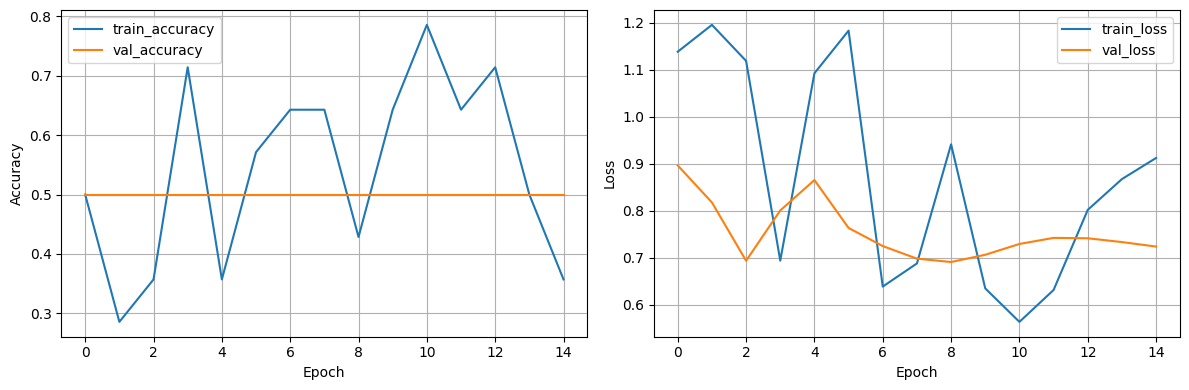

In [58]:
def plot_history(history: keras.callbacks.History) -> None:
    metrics = ["accuracy", "loss"]
    plt.figure(figsize=(12, 4))
    for idx, metric in enumerate(metrics, 1):
        plt.subplot(1, 2, idx)
        plt.plot(history.history[metric], label=f"train_{metric}")
        val_metric = f"val_{metric}"
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f"val_{metric}")
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()


if history is not None:
    plot_history(history)
else:
    print("No training history to plot.")


## **4.5. Training Diagnostics**

Understanding your training metrics - especially important for small datasets.


In [59]:
# Diagnostic: Understand validation behavior
if data_bundle is not None and history is not None:
    val_size = len(data_bundle["val_df"]) if len(data_bundle["val_df"]) > 0 else 0
    train_size = len(data_bundle["train_df"])
    
    print("=" * 70)
    print("📊 DATASET SIZE ANALYSIS")
    print("=" * 70)
    print(f"Training samples: {train_size}")
    print(f"Validation samples: {val_size}")
    test_size = len(data_bundle['test_df']) if len(data_bundle['test_df']) > 0 else 0
    print(f"Test samples: {test_size}")
    
    if val_size > 0:
        print(f"\n📋 Validation set breakdown:")
        val_counts = data_bundle["val_df"]["label"].value_counts()
        for label, count in val_counts.items():
            print(f"  • {label}: {count} image(s)")
    
    print("\n" + "=" * 70)
    print("🔍 WHY VALIDATION ACCURACY MIGHT BE CONSTANT")
    print("=" * 70)
    
    if val_size <= 2:
        print("⚠️  PROBLEM DETECTED: Very small validation set!")
        print(f"\nWith only {val_size} validation image(s), accuracy can only be:")
        if val_size == 1:
            print("  • 0% (wrong)")
            print("  • 100% (correct)")
        else:
            print("  • 0% (0 out of 2 correct)")
            print("  • 50% (1 out of 2 correct)")
            print("  • 100% (2 out of 2 correct)")
        
        print("\nThis explains why validation accuracy appears 'stuck' -")
        print("it can only change in these large jumps, not smoothly.")
        print("\n✅ Validation LOSS can still decrease because:")
        print("  • Loss measures confidence/probability, not just correctness")
        print("  • Even if predictions don't change, confidence can increase")
        print("  • Example: Predicting 'class A' with 60% confidence → 40% confidence")
        print("    Both might be correct, but loss decreases as confidence increases")
        print("\n💡 SOLUTION: Add more images to your dataset!")
        print("   Aim for at least 20-30 images per class for meaningful validation.")
    elif val_size < 10:
        print(f"⚠️  Small validation set ({val_size} images)")
        print("Validation accuracy will be less reliable and may appear constant.")
        print("Consider adding more images for better validation metrics.")
    else:
        print("✓ Validation set size is reasonable.")
    
    # Show actual validation predictions if possible
    if val_size > 0 and model is not None:
        print("\n" + "=" * 70)
        print("🔬 VALIDATION PREDICTIONS (for debugging)")
        print("=" * 70)
        val_ds = data_bundle["val"]
        if val_ds is not None:
            for images, labels in val_ds.take(1):
                preds = model.predict(images, verbose=0)
                true_labels = tf.argmax(labels, axis=1).numpy()
                pred_labels = tf.argmax(preds, axis=1).numpy()
                
                for i in range(len(true_labels)):
                    true_class = data_bundle["index_to_class"][int(true_labels[i])]
                    pred_class = data_bundle["index_to_class"][int(pred_labels[i])]
                    confidence = float(preds[i][pred_labels[i]])
                    correct = "✓" if true_labels[i] == pred_labels[i] else "✗"
                    print(f"  {correct} True: {true_class:15s} | Pred: {pred_class:15s} | Conf: {confidence:.3f}")
    
    # Show validation metrics from history
    if "val_accuracy" in history.history:
        print("\n" + "=" * 70)
        print("📈 VALIDATION METRICS SUMMARY")
        print("=" * 70)
        val_acc = history.history["val_accuracy"]
        val_loss = history.history["val_loss"]
        print(f"Validation accuracy range: {min(val_acc):.3f} - {max(val_acc):.3f}")
        print(f"Validation loss range: {min(val_loss):.3f} - {max(val_loss):.3f}")
        if len(set(val_acc)) == 1:
            print("⚠️  Validation accuracy is constant (all epochs have same value)")
            print("   This confirms the validation set is too small for meaningful accuracy tracking.")
    
    print("\n" + "=" * 70)
else:
    print("Run training first to see diagnostics.")


📊 DATASET SIZE ANALYSIS
Training samples: 14
Validation samples: 4
Test samples: 3

📋 Validation set breakdown:
  • greater: 2 image(s)
  • socotra: 2 image(s)

🔍 WHY VALIDATION ACCURACY MIGHT BE CONSTANT
⚠️  Small validation set (4 images)
Validation accuracy will be less reliable and may appear constant.
Consider adding more images for better validation metrics.

🔬 VALIDATION PREDICTIONS (for debugging)
  ✗ True: socotra         | Pred: greater         | Conf: 0.509
  ✓ True: greater         | Pred: greater         | Conf: 0.518
  ✓ True: greater         | Pred: greater         | Conf: 0.508
  ✗ True: socotra         | Pred: greater         | Conf: 0.513

📈 VALIDATION METRICS SUMMARY
Validation accuracy range: 0.500 - 0.500
Validation loss range: 0.691 - 0.896
⚠️  Validation accuracy is constant (all epochs have same value)
   This confirms the validation set is too small for meaningful accuracy tracking.



## **5. Evaluation & Diagnostics**

Run evaluation on the held-out test set, visualize predictions, and inspect the confusion matrix.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6667 - loss: 0.6773
{'loss': 0.6773059964179993, 'compile_metrics': 0.6666666865348816}

Classification report:
               precision    recall  f1-score   support

     greater     0.6667    1.0000    0.8000         2
     socotra     0.0000    0.0000    0.0000         1

    accuracy                         0.6667         3
   macro avg     0.3333    0.5000    0.4000         3
weighted avg     0.4444    0.6667    0.5333         3



2025-11-07 22:07:16.132725: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/raoabdul/Documents/Development/NextGen-Innovators/nextgen/lib/python3.13/site-packages/skl

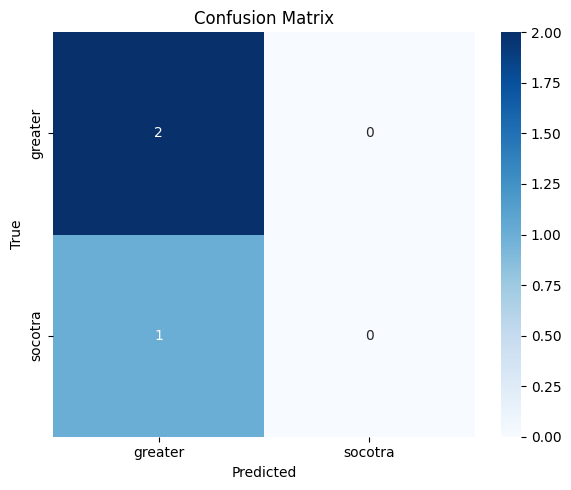

In [60]:
from sklearn.metrics import classification_report, confusion_matrix


def evaluate_model(model: keras.Model, data_bundle: dict) -> Dict[str, np.ndarray]:
    test_ds = data_bundle["test"]
    if test_ds is None:
        raise ValueError("Test dataset is empty. Provide more images per class.")

    test_results = model.evaluate(test_ds, verbose=1)
    print(dict(zip(model.metrics_names, test_results)))

    y_true = []
    y_pred = []
    for images, labels in test_ds:
        logits = model.predict(images, verbose=0)
        y_true.extend(tf.argmax(labels, axis=1).numpy())
        y_pred.extend(tf.argmax(logits, axis=1).numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    report = classification_report(
        y_true,
        y_pred,
        target_names=[data_bundle["index_to_class"][i] for i in range(len(data_bundle["index_to_class"]))],
        digits=4,
    )
    print("\nClassification report:\n", report)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[data_bundle["index_to_class"][i] for i in range(len(cm))],
        yticklabels=[data_bundle["index_to_class"][i] for i in range(len(cm))],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return {"y_true": y_true, "y_pred": y_pred, "cm": cm}


if model is not None and data_bundle is not None and data_bundle["test"] is not None:
    evaluation_outputs = evaluate_model(model, data_bundle)
else:
    evaluation_outputs = None
    print("Evaluation skipped. Ensure model is trained and test set is available.")


## **6. Single Image Inference Helper**

Use the helper below to classify individual images. Provide a path to any image file after training.


In [64]:
def predict_image(path: Path, model: keras.Model, index_to_class: Dict[int, str]) -> Dict[str, float]:
    image = load_image(tf.convert_to_tensor(str(path)))
    image = tf.expand_dims(image, axis=0)
    preds = model.predict(image, verbose=0)[0]
    return {
        index_to_class[idx]: float(prob)
        for idx, prob in enumerate(preds)
    }


def display_prediction(predictions: Dict[str, float]) -> None:
    items = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    for label, prob in items:
        print(f"{label}: {prob:.3f}")


# Example usage (update the path after adding images)
example_image_path = IMAGE_DIR / "sample_image.jpeg"
if model is not None and example_image_path.exists():
    probs = predict_image(example_image_path, model, data_bundle["index_to_class"])
    display_prediction(probs)
else:
    print("Set `example_image_path` to an existing image after training to see predictions.")


greater: 0.504
socotra: 0.496


## **7. Realtime Webcam Inference (Optional)**

The cell below captures frames from your default webcam, runs classification, and overlays the predicted label. Install OpenCV (`pip install opencv-python`) if it's not already available. Press `q` to quit the loop.


In [62]:
if cv2 is None:
    print("OpenCV is not installed. Run `pip install opencv-python` and restart the kernel before executing this cell.")
elif model is None or data_bundle is None:
    print("Train the model before running webcam inference.")
else:
    label_colors = {
        label: tuple(np.random.randint(0, 255, size=3).tolist())
        for label in data_bundle["class_to_index"].keys()
    }

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Unable to access the webcam. Check camera permissions or device connection.")
    else:
        try:
            while True:
                ret, frame = cap.read()
                if not ret:
                    print("Failed to read frame from webcam.")
                    break

                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(rgb_frame)
                resized = pil_image.resize(IMG_SIZE)
                input_arr = np.array(resized, dtype=np.float32) / 255.0
                input_arr = np.expand_dims(input_arr, axis=0)

                preds = model.predict(input_arr, verbose=0)[0]
                best_idx = int(np.argmax(preds))
                best_label = data_bundle["index_to_class"][best_idx]
                best_prob = float(preds[best_idx])

                text = f"{best_label}: {best_prob:.2f}"
                color = label_colors[best_label]
                cv2.putText(
                    frame,
                    text,
                    (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.0,
                    color,
                    2,
                    cv2.LINE_AA,
                )

                cv2.imshow("Realtime Classification", frame)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
        finally:
            cap.release()
            cv2.destroyAllWindows()


Failed to read frame from webcam.


## **8. Save and Reload Model**

Persist the trained model and provide a simple loader. This allows you to reuse the classifier without retraining every session.


In [63]:
MODEL_PATH = ARTIFACT_DIR / "visual_classifier.keras"
METADATA_PATH = ARTIFACT_DIR / "class_mapping.json"

if model is not None and data_bundle is not None:
    model.save(MODEL_PATH)
    with open(METADATA_PATH, "w") as f:
        json.dump(data_bundle["index_to_class"], f, indent=2)
    print(f"Model saved to {MODEL_PATH}")
    print(f"Class mapping saved to {METADATA_PATH}")
else:
    print("Model not saved. Train the model first.")


def load_model_and_mapping(model_path: Path, metadata_path: Path):
    loaded_model = keras.models.load_model(model_path)
    with open(metadata_path) as f:
        index_to_class = {int(k): v for k, v in json.load(f).items()}
    return loaded_model, index_to_class


# Example reload usage (uncomment after training and saving)
# reloaded_model, index_to_class = load_model_and_mapping(MODEL_PATH, METADATA_PATH)
# display_prediction(predict_image(example_image_path, reloaded_model, index_to_class))


Model saved to /Users/raoabdul/Documents/Development/NextGen-Innovators/Ml Model/artifacts/visual_classifier.keras
Class mapping saved to /Users/raoabdul/Documents/Development/NextGen-Innovators/Ml Model/artifacts/class_mapping.json


## **9. Next Steps Checklist**

- Add class-balanced images into `images/`.
- Run the notebook sequentially from top to bottom.
- Monitor training curves and adjust hyperparameters as needed.
- Test with realtime webcam inference once satisfied with model accuracy.
- Consider augmenting the dataset or using transfer learning for improved performance.
